In [1]:
import iminuit
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal

import CohesiveCrack
import DataProcessor

In [2]:
Gamma = 0.21  # Fracture energy (J/m^2)
E = 51e9      # Young's modulus (Pa)
nu = 0.25     # Poisson's ratio
C_f = 2404    # Rupture speed (m/s)
C_s = 2760    # Shear wave speed (m/s)
C_d = 4790    # Longitudinal wave speed (m/s)

In [3]:
experiment_SN = 'p5993'
normal_stress = 20 * 10**6 # Pa

In [4]:
filename = f'../Data/{experiment_SN}e.npz'

In [5]:
run_number = 2
event_number = 8

In [6]:
PROMINENCES = [0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02]
DISTANCES = [30, 30, 30, 30, 30, 30, 30, 30, 30]

X_C_INITIALS = [3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000]
GAMMA_INITIALS = [4000, 4000, 4000, 4000, 4000, 4000, 4000, 4000, 4000]
PEAK_INDEXS = [0, 0, 0, 0, 0, 0, 0, 0, 0]
PEAK_FIND_SPAN = [120, 120, 120, 220, 120, 120, 120, 120, 120]

MAX_INDEXS = [np.NaN, np.NaN, np.NaN, np.NaN, np.NaN, np.NaN, np.NaN]

# to be refine: 
#   1) event_number:

In [7]:
data = np.load(filename, allow_pickle = True)
data = data["experiment"][()]
event = data['runs'][1]['events'][event_number]
exy6 = event['strain']['original']['raw'][6]


TIME_S = event['strain']['original']['time']
C_f = np.abs(event['rupture_speed'])
print(f'Cf: {C_f:.1f}m/s')

fs = len(TIME_S) / (np.max(TIME_S) - np.min(TIME_S))
print(f'Sampling rate: {fs:.1f}Hz')

DISTANCE = TIME_S * C_f * 1000 # mm


STRAIN = DataProcessor.voltage_to_strain(exy6)
STRESS = DataProcessor.shear_strain_to_stress(E, nu, STRAIN)
STRESS = STRESS - STRESS[0]
STRESS_MPA = STRESS / 10**6
STRESS_MPA *= -1

Cf: 1680.0m/s
Sampling rate: 100000.2Hz


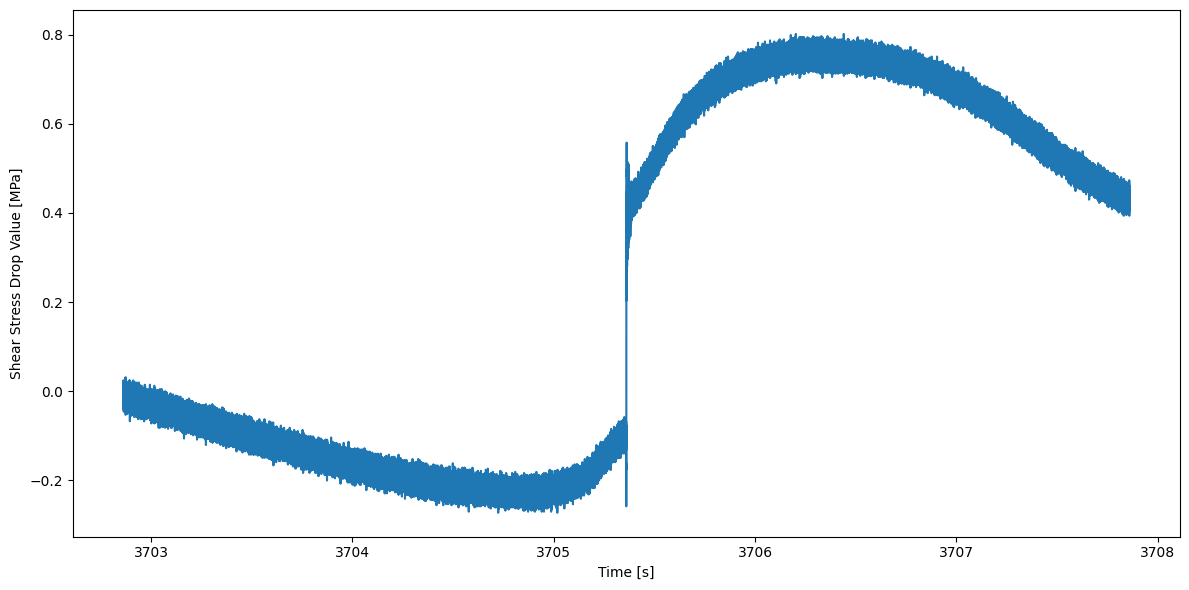

In [8]:
plt.figure(figsize = (12, 6))
plt.plot(TIME_S, STRESS_MPA, label=r'$\epsilon_{xy}$')
plt.xlabel('Time [s]')
plt.ylabel('Shear Stress Drop Value [MPa]')
# plt.plot(event['strain']['original']['time'], eyy6 - eyy6[0], label=r'$\epsilon_{yy}$')
plt.tight_layout()
plt.savefig(f'../Plot/{experiment_SN}.pdf', dpi = 300)
plt.show()
plt.close()

In [9]:
cutoff = 100
FILTERED_STRESS_MPA = DataProcessor.highpass_filter(STRESS_MPA, cutoff, fs)

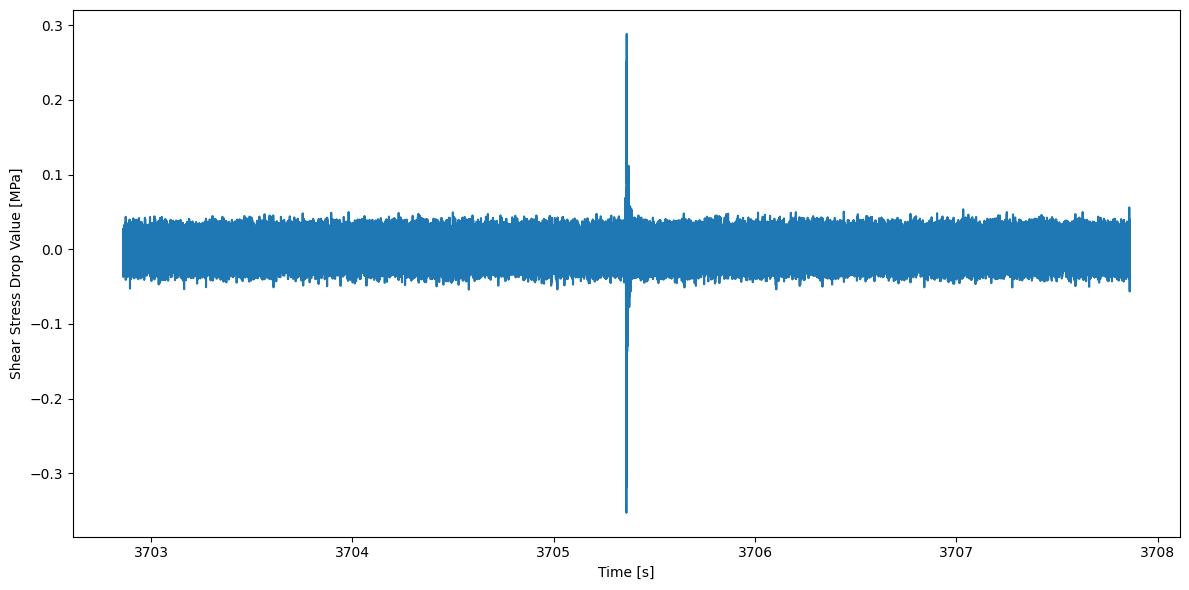

In [10]:
plt.figure(figsize = (12, 6))
plt.plot(TIME_S, FILTERED_STRESS_MPA, label=r'$\epsilon_{xy}$')
plt.xlabel('Time [s]')
plt.ylabel('Shear Stress Drop Value [MPa]')
plt.tight_layout()
plt.savefig(f'../Plot/Filtered-{experiment_SN}.pdf', dpi = 300)
plt.show()
plt.close()

In [11]:
hspan = 2000


# STA, LTA window length
sta_window = 40   # STA window length
lta_window = 300  # LTA window length

# Calculate STA, LTA by convolution
sta = np.convolve(FILTERED_STRESS_MPA**2, np.ones(sta_window)/sta_window, mode='valid')
lta = np.convolve(FILTERED_STRESS_MPA**2, np.ones(lta_window)/lta_window, mode='valid')

# Matching STA and LTA data length
min_length = min(len(sta), len(lta))
sta = sta[:min_length]
lta = lta[:min_length]

# Calculate LTA/STA ratio
lta_sta_ratio = sta / lta

# Find peak and peak's index
max_ratio = np.max(lta_sta_ratio)
max_index = np.argmax(lta_sta_ratio)

In [12]:
start_index = max_index - PEAK_FIND_SPAN[event_number]
end_index   = max_index + PEAK_FIND_SPAN[event_number]

CUT_STRESS_MPA = STRESS_MPA[start_index:end_index]
LOCAL_PEAKS, _ = scipy.signal.find_peaks(CUT_STRESS_MPA, prominence = PROMINENCES[event_number], distance = DISTANCES[event_number])
GLOBAL_PEAKS = LOCAL_PEAKS + start_index

GLOBAL_PEAK = GLOBAL_PEAKS[PEAK_INDEXS[event_number]]

print(f'Peaks: {GLOBAL_PEAK}')
print(f'Peak Values: {STRESS_MPA[GLOBAL_PEAK]}')

Peaks: 250018
Peak Values: 0.4106046828824739


In [13]:
# DISTANCE = DISTANCE - DISTANCE[GLOBAL_PEAK]
# STRESS_MPA = STRESS_MPA - np.average(STRESS_MPA[max_index - hspan: max_index - hspan + 1000])

DISTANCE = DISTANCE - DISTANCE[GLOBAL_PEAK]
STRESS_MPA = STRESS_MPA - np.min(STRESS_MPA[GLOBAL_PEAK - 180:GLOBAL_PEAK])

Xc_fit   : 742.880
Gamma_fit: 4657.090
<ErrorView X_c=187.30078213116013 Gamma=4846.2543560786435>


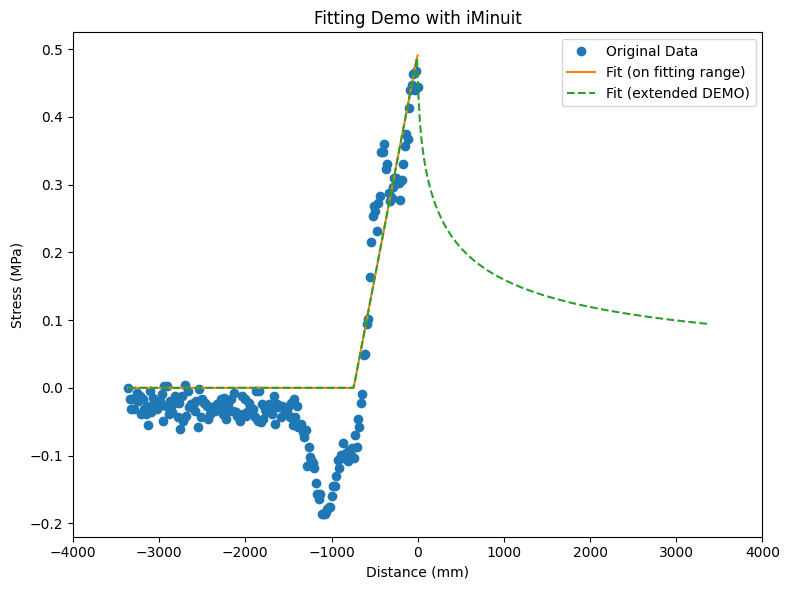

In [14]:
STRESS_MPA_FOR_FIT = STRESS_MPA[GLOBAL_PEAK - 200: GLOBAL_PEAK]     # fitting range
STRESS_MPA_FOR_FIT = STRESS_MPA_FOR_FIT - STRESS_MPA_FOR_FIT[0]     # shift to zero
DISTANCE_FOR_FIT = np.linspace(-200, 0, 200) / fs * C_f * 1000      # mm
DISTANCE_FOR_DEMO = np.linspace(-200, 200, 400) / fs * C_f * 1000   # mm

# ------------------------------------------------------------------------
# (1) Define chi-square function
# ------------------------------------------------------------------------
def chi_square(X_c, Gamma):
    
    model = DataProcessor.fitting_function(X_c, C_f, Gamma, DISTANCE_FOR_FIT, 8e-3) / 10**6

    # chi2 = sum( (data_i - model_i)^2 / sigma_i^2 )
    chi2 = np.sum((STRESS_MPA_FOR_FIT - model)**2)
    return chi2

# ------------------------------------------------------------------------
# (2) Use iminuit to find chi-square min
# ------------------------------------------------------------------------
m = iminuit.Minuit(chi_square, X_c = X_C_INITIALS[event_number], Gamma = GAMMA_INITIALS[event_number])

# errordef = 1 corresponding to Least-Squares / Chi-square
m.errordef = 1

# Do fitting
m.migrad()

# Check fitting uncertainties
m.hesse()

# Get fitting results
Xc_fit = m.values["X_c"]
Gamma_fit = m.values["Gamma"]

print(f"Xc_fit   : {Xc_fit:.3f}")
print(f"Gamma_fit: {Gamma_fit:.3f}")

print(m.errors)

# ------------------------------------------------------------------------
# (3) Plotting：Compare fitting result with raw data
# ------------------------------------------------------------------------
# 0) Setup Figure
plt.figure(figsize = (8, 6))

# 1) raw data (from 0, to 180), 180 points
plt.plot(DISTANCE_FOR_FIT, STRESS_MPA_FOR_FIT, "o", label="Original Data")

# 2) draw the fitting curve "corresponding to DISTANCE_FOR_FIT"
STRESS_MPA_FIT_CURVE = DataProcessor.fitting_function(Xc_fit, C_f, Gamma_fit, DISTANCE_FOR_FIT, 8e-3) / 10**6
plt.plot(DISTANCE_FOR_FIT, STRESS_MPA_FIT_CURVE, "-", label="Fit (on fitting range)")

# 3) expand the scope
STRESS_MPA_FOR_DEMO = DataProcessor.fitting_function(Xc_fit, C_f, Gamma_fit, DISTANCE_FOR_DEMO, 8e-3) / 10**6
plt.plot(DISTANCE_FOR_DEMO, STRESS_MPA_FOR_DEMO, "--", label="Fit (extended DEMO)")

# set x range
plt.xlim(-4000, 4000)
plt.xlabel("Distance (mm)")
plt.ylabel("Stress (MPa)")
plt.legend()
plt.title("Fitting Demo with iMinuit")
plt.tight_layout()
plt.savefig(f'../Plot/Fitting-{experiment_SN}.pdf', dpi = 300)
plt.show()
plt.close()

In [15]:
theta = Gamma_fit / normal_stress / (Xc_fit * 10**3)

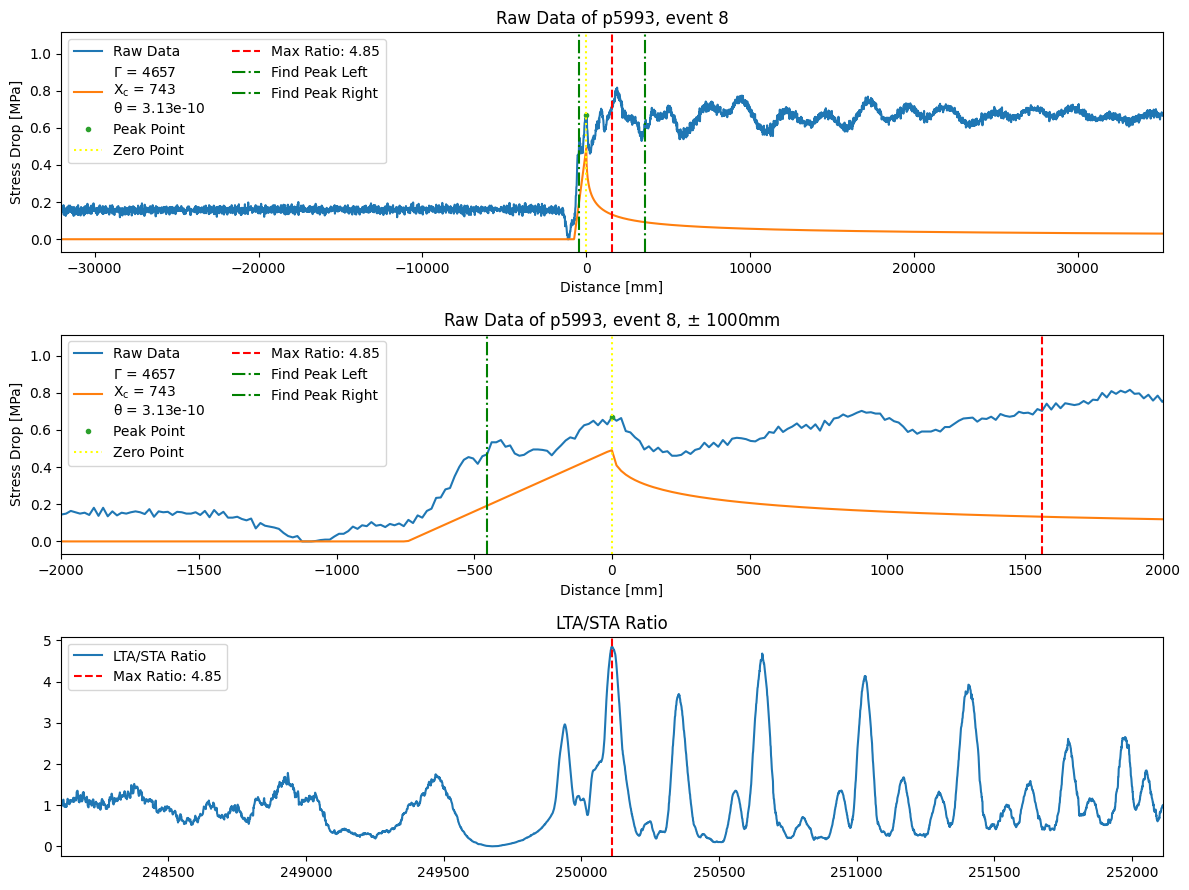

In [16]:
plt.rcParams.update({'mathtext.default': 'regular'})
plt.figure(figsize = (12, 9))

# Plot raw data (No filter)
plt.subplot(3, 1, 1)
plt.plot(DISTANCE, STRESS_MPA, label = 'Raw Data')
plt.plot(DISTANCE, DataProcessor.fitting_function(Xc_fit, C_f, Gamma_fit, DISTANCE, 8e-3) / 10**6, label = f'$\Gamma$ = {Gamma_fit:.0f}\n$X_c$ = {Xc_fit:.0f}\n$\\theta$ = {theta:.3g}')
plt.plot(DISTANCE[GLOBAL_PEAK], STRESS_MPA[GLOBAL_PEAK], '.', label = 'Peak Point')
plt.xlabel('Distance [mm]')
plt.ylabel('Stress Drop [MPa]')
plt.axvline(x = DISTANCE[GLOBAL_PEAK], color = 'yellow', linestyle = ':', label = 'Zero Point')
plt.axvline(x = DISTANCE[max_index], color = 'red', linestyle = '--', label=f'Max Ratio: {max_ratio:.2f}')
plt.axvline(x = DISTANCE[start_index], color = 'green', linestyle = '-.', label = f'Find Peak Left')
plt.axvline(x = DISTANCE[end_index], color = 'green', linestyle = '-.', label = f'Find Peak Right')
plt.xlim(DISTANCE[max_index - hspan], DISTANCE[max_index + hspan])
plt.title(f'Raw Data of {experiment_SN}, event {event_number}')
plt.legend(ncol = 2, loc = 'upper left')

# Plot raw data (\pm 2000mm)
plt.subplot(3, 1, 2)
plt.plot(DISTANCE, STRESS_MPA, label = 'Raw Data')
plt.plot(DISTANCE, DataProcessor.fitting_function(Xc_fit, C_f, Gamma_fit, DISTANCE, 8e-3) / 10**6, label = f'$\Gamma$ = {Gamma_fit:.0f}\n$X_c$ = {Xc_fit:.0f}\n$\\theta$ = {theta:.3g}')
plt.plot(DISTANCE[GLOBAL_PEAK], STRESS_MPA[GLOBAL_PEAK], '.', label = 'Peak Point')
plt.xlabel('Distance [mm]')
plt.ylabel('Stress Drop [MPa]')
plt.axvline(x = DISTANCE[GLOBAL_PEAK], color = 'yellow', linestyle = ':', label = 'Zero Point')
plt.axvline(x = DISTANCE[max_index], color = 'red', linestyle = '--', label=f'Max Ratio: {max_ratio:.2f}')
plt.axvline(x = DISTANCE[start_index], color = 'green', linestyle = '-.', label = f'Find Peak Left')
plt.axvline(x = DISTANCE[end_index], color = 'green', linestyle = '-.', label = f'Find Peak Right')
plt.xlim(-2000, 2000)
plt.title(f'Raw Data of {experiment_SN}, event {event_number}, $\pm$ 1000mm')
plt.legend(ncol = 2, loc = 'upper left')

# Plot LTA/STA ratio
plt.subplot(3, 1, 3)
plt.plot(lta_sta_ratio, label='LTA/STA Ratio')
plt.axvline(x = max_index, color = 'red', linestyle = '--', label=f'Max Ratio: {max_ratio:.2f}')
plt.xlim(max_index - hspan, max_index + hspan)
plt.title('LTA/STA Ratio')
plt.legend(loc = 'upper left')

plt.tight_layout()
plt.savefig(f'../Plot/STA-LTA-{experiment_SN}-{event_number}.pdf')
plt.show()
plt.close()

In [17]:
event['gamma'] = Gamma_fit
event['X_c'] = Xc_fit
np.savez(filename, experiment=data)